### Imports

In [1]:
import polars as pl
import pandas as pd
from scipy import stats
import numpy as np
import joblib
import os
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

### Constants

In [2]:
RANDOM_STATE = 1
FILES_DIR = "../data"
os.makedirs(FILES_DIR, exist_ok=True)
MODELS_DIR = "../models"
os.makedirs(MODELS_DIR, exist_ok=True)

### Upload CatBoost

In [3]:
file_name = "xy_train_test.joblib"
file_path = os.path.join(FILES_DIR, file_name)
xy_train_test = joblib.load(file_path)
X_test = xy_train_test["X_test"]
X_train = xy_train_test["X_train"]
y_train = xy_train_test["y_train"]
y_test = xy_train_test["y_test"]

In [4]:
file_name = "catboost_subset_genetics_cyp.joblib"
file_path = os.path.join(MODELS_DIR, file_name)
model = joblib.load(file_path)

In [5]:
def scale_predictions(preds, min_value, max_value):
    scaled = (preds - min_value) / (max_value - min_value)
    return scaled


train_predictions = model.predict_proba(X_train)
min_value = train_predictions.min()
max_value = train_predictions.max()

In [6]:
result_df = pd.DataFrame()
result_df["fact"] = y_test
inference_df = X_test.copy()
for i in X_test["P2Y12 inhibitor"].unique():
    inference_df["P2Y12 inhibitor"] = i
    preds = model.predict_proba(inference_df)[:, 1]
    result_df[f"preds_{i}"] = preds

In [7]:
result_df["diff"] = result_df["preds_1"] - result_df["preds_2"]

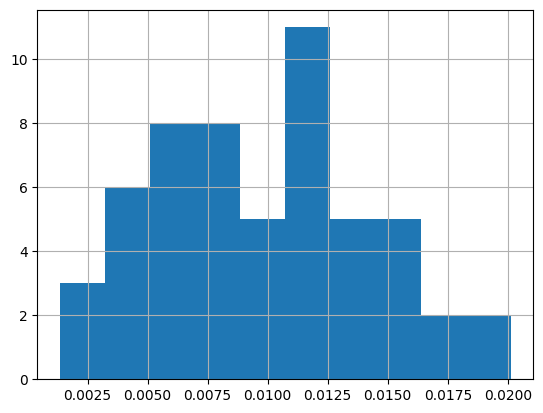

In [8]:
plt.hist(result_df["diff"], bins=10)
plt.grid()

In [9]:
from sklift.metrics import qini_auc_score, uplift_auc_score

auqc_score = qini_auc_score(
    y_test,
    result_df["diff"],
    X_test["P2Y12 inhibitor"] % 2,
)
print(f"Qini AUC score: \t{auqc_score.round(4)}")

auuc_score = uplift_auc_score(
    y_test,
    result_df["diff"],
    X_test["P2Y12 inhibitor"] % 2,
)
print(f"Uplift AUC score: \t{auuc_score.round(4)}")

Qini AUC score: 	0.4002
Uplift AUC score: 	0.4776


### shift distribution

In [10]:
def calculate_shift_distribution(
    test_df: pd.DataFrame,
    model: CatBoostClassifier,
    n_samples: int,
) -> list[float]:
    pass
    mean_diff = []
    prediction_values = sorted(test_df["P2Y12 inhibitor"].unique())
    for iteration in tqdm(range(5000)):
        result_df = pd.DataFrame()
        inference_df = test_df.copy().sample(n_samples, replace=True)

        for i in prediction_values:
            inference_df["P2Y12 inhibitor"] = i
            preds = model.predict_proba(inference_df)[:, 1]
            result_df[f"preds_{i}"] = scale_predictions(preds, min_value, max_value)

        result_df["diff"] = result_df["preds_1"] - result_df["preds_2"]

        mean_diff.append(result_df["diff"].mean())

    return mean_diff

In [11]:
mean_diff = calculate_shift_distribution(
    test_df=X_test,
    model=model,
    n_samples=30,
)

100%|██████████| 5000/5000 [00:09<00:00, 503.30it/s]


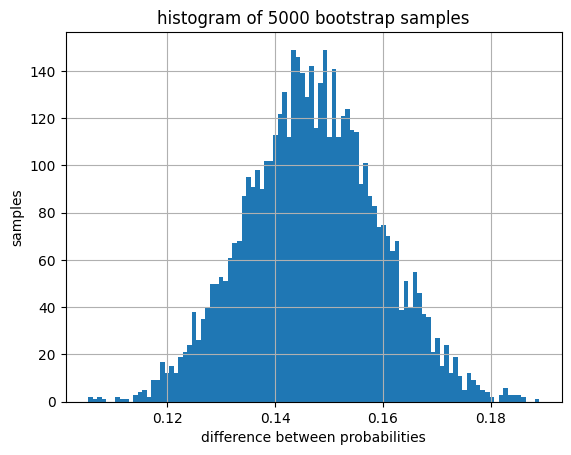

In [12]:
plt.hist(mean_diff, bins=100)
plt.xlabel("difference between probabilities")
plt.ylabel("samples")
plt.title("histogram of 5000 bootstrap samples")
plt.grid()

### compare distributions for two types of genes

In [13]:
# X_train["P2Y12 inhibitor"].value_counts()
X_test["All Negative CYP2C19"].value_counts()

All Negative CYP2C19
1    34
0    21
Name: count, dtype: int64

In [14]:
y_test[X_test["All Negative CYP2C19"] == 0].value_counts()

combined
0    14
1     7
Name: count, dtype: int64

In [15]:
y_test[X_test["All Negative CYP2C19"] == 1].value_counts()

combined
1    24
0    10
Name: count, dtype: int64

In [16]:
mean_diff_has_mutation = calculate_shift_distribution(
    test_df=X_test[X_test["All Negative CYP2C19"] == 1],
    model=model,
    n_samples=15,
)

100%|██████████| 5000/5000 [00:08<00:00, 610.55it/s]


In [17]:
mean_diff_no_mutation = calculate_shift_distribution(
    test_df=X_test[X_test["All Negative CYP2C19"] == 0],
    model=model,
    n_samples=15,
)

100%|██████████| 5000/5000 [00:08<00:00, 597.97it/s]


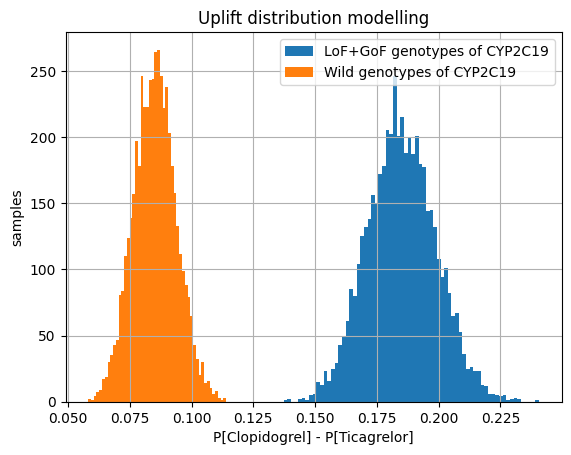

In [21]:
plt.hist(mean_diff_has_mutation, bins=70, label="LoF+GoF genotypes of CYP2C19")
plt.hist(mean_diff_no_mutation, bins=50, label="Wild genotypes of CYP2C19")
plt.xlabel("P[Clopidogrel] - P[Ticagrelor]")
plt.ylabel("samples")
plt.title("Uplift distribution modelling")
plt.legend()
plt.grid()

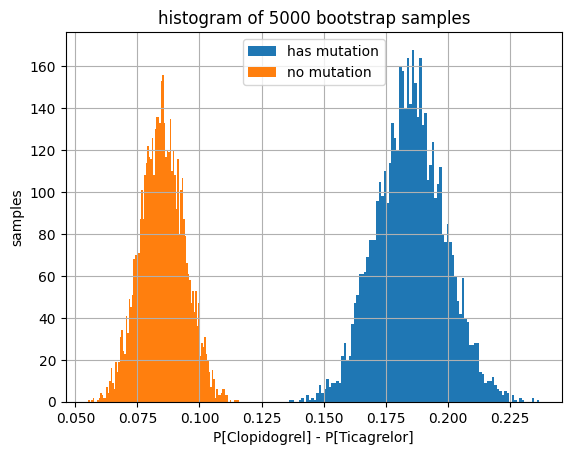

In [ ]:
plt.hist(mean_diff_has_mutation, bins=100, label="has mutation")
plt.hist(mean_diff_no_mutation, bins=100, label="no mutation")
plt.xlabel("P[Clopidogrel] - P[Ticagrelor]")
plt.ylabel("samples")
plt.title("Distribu")
plt.legend()
plt.grid()

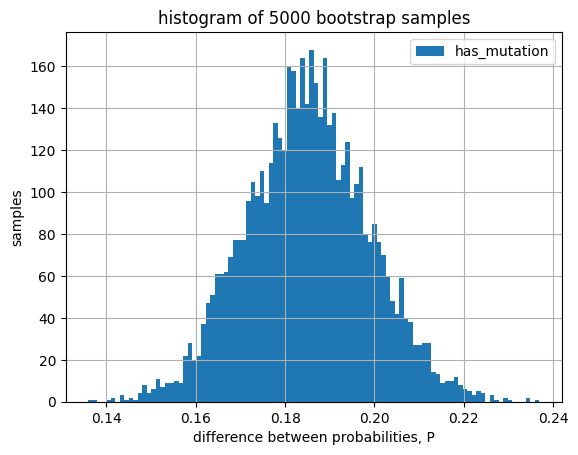

In [47]:
plt.hist(mean_diff_has_mutation, bins=100, label="has_mutation")
# plt.hist(mean_diff_no_mutation, bins=100, label="no_mutation")
plt.xlabel("difference between probabilities, P")
plt.ylabel("samples")
plt.title("histogram of 5000 bootstrap samples")
plt.legend()
plt.grid()

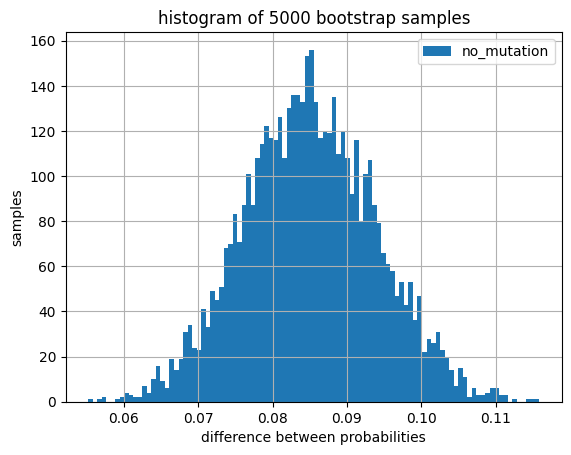

In [48]:
plt.hist(mean_diff_no_mutation, bins=100, label="no_mutation")
plt.xlabel("difference between probabilities")
plt.ylabel("samples")
plt.title("histogram of 5000 bootstrap samples")
plt.legend()
plt.grid()

<BarContainer object of 7 artists>

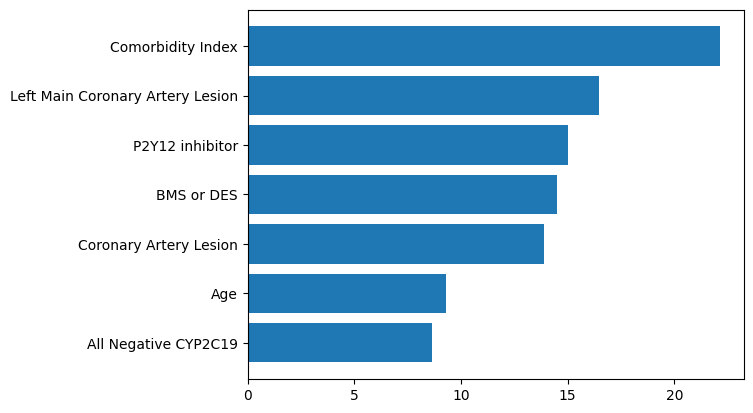

In [49]:
z = pd.DataFrame(
    {
        "imps": model.feature_importances_,
        "feats": model.feature_names_,
    }
).sort_values("imps")

plt.barh(
    z["feats"],
    z["imps"],
)